<a href="https://colab.research.google.com/github/YordanIg/learning-ML/blob/main/timeseries_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use an RNN to predict a sine curve timeseries.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

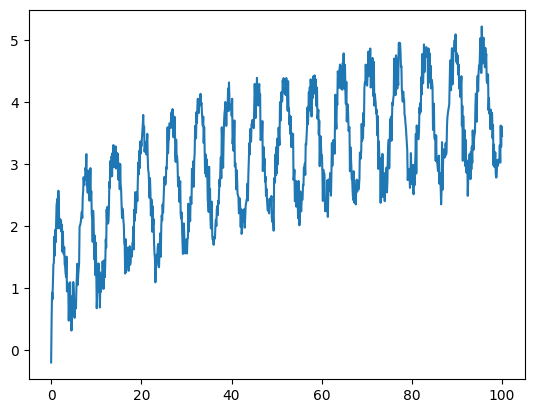

In [54]:
# Create a timeseries signal.
timesteps = torch.linspace(0,100,1000)
signal = torch.sin(timesteps) + timesteps**0.3 + 0.2*torch.randn_like(timesteps)
plt.plot(timesteps, signal)
plt.show()

In [62]:
# Create sliding window data, of standard shape:
#   X : (num_samples, window_size, input_dim)
#   Y : (num_samples, output_dim)
ws = 10
X, Y = [], []
for i in range(len(signal)-ws):
  X.append(signal[i:i+ws])
  Y.append(signal[i+ws])
X = torch.stack(X).view(-1,ws,1)
Y = torch.tensor(Y).view(-1,1)

# Split into training and testing data.
test_size = 200
X_train, Y_train = X[:-test_size], Y[:-test_size]
X_test, Y_test = X[-test_size:], Y[-test_size:]

# Create the training data loader.
batch_size = 32
trainloader = DataLoader(dataset=TensorDataset(X_train, Y_train),
                         batch_size=batch_size, shuffle=True)

In [63]:
class RNN(nn.Module):
  """
  Simple RNN model, which takes a batched input vector x of shape
    (batch_size, window_size, input_size),
  and runs each timestep (the middle dimension) of x through the model,
  computing a new hidden state which is combined with the next timestep of x.

  The output of the final timestep, as a function of the input and the hidden
  state corresponds to the prediction of the next timestep.
  """
  def __init__(self, input_size, hidden_size, output_size):
    """
    Args:
      input_size: The number of features of the data.
      hidden_size: The number of hidden model dimensions.
      output_size: The number of output features.
    """
    super().__init__()
    self.hidden_size = hidden_size

    self.U = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.W = nn.Linear(in_features=hidden_size, out_features=hidden_size,
                       bias=False)
    self.V = nn.Linear(in_features=hidden_size, out_features=output_size)

  def forward(self, x):
    batch_size, window_size, _ = x.shape
    h = torch.zeros(batch_size, self.hidden_size)  # Create empty hidden state.
    for t in range(window_size):
      xt = x[:,t,:]
      hidden_state = self.U(xt) + self.W(h)
      hidden_state = F.sigmoid(hidden_state)
      h = hidden_state
    y = self.V(h)  # No activation as the model is intended for regression.
    return y


In [81]:
# Test the model instantiation.
model = RNN(1, 128, 1)
testout = model(torch.randn(16, 10, 1))
print(testout.shape)

torch.Size([16, 1])


In [82]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
num_epochs = 20
all_loss = []
for epoch in range(num_epochs):
  for i, data in enumerate(trainloader):
    optimizer.zero_grad()
    x, y = data
    predictions = model(x)
    loss = criterion(predictions, y)
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
  print(f"Epoch {epoch} complete.")
print("Training complete.")

Epoch 0 complete.
Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.
Epoch 6 complete.
Epoch 7 complete.
Epoch 8 complete.
Epoch 9 complete.
Epoch 10 complete.
Epoch 11 complete.
Epoch 12 complete.
Epoch 13 complete.
Epoch 14 complete.
Epoch 15 complete.
Epoch 16 complete.
Epoch 17 complete.
Epoch 18 complete.
Epoch 19 complete.
Training complete.


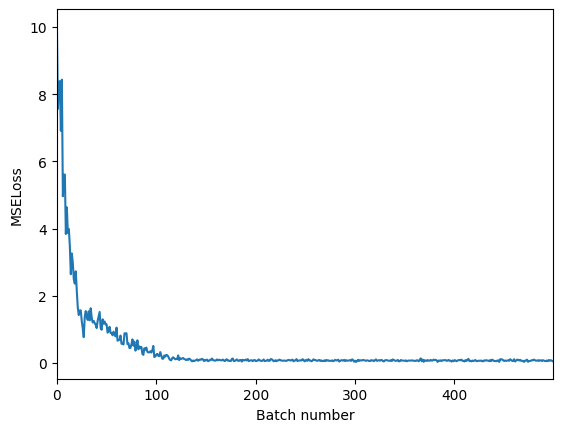

In [84]:
plt.plot(all_loss)
plt.ylabel("MSELoss")
plt.xlabel("Batch number")
plt.xlim(0,len(all_loss)-1)
plt.show()

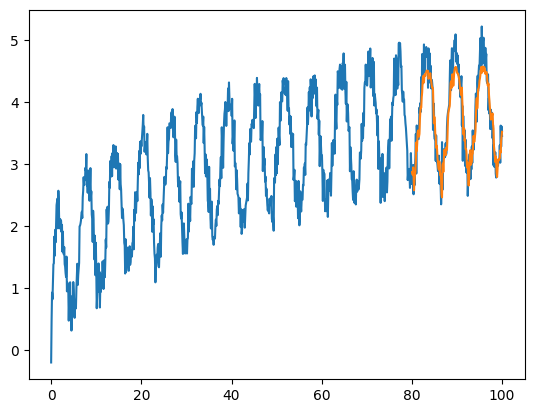

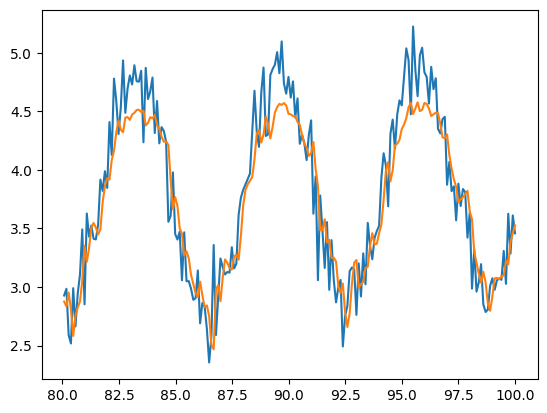

In [87]:
# Test the model's predictions of the last bit of the sample function.
with torch.no_grad():
  plt.plot(timesteps, signal)
  plt.plot(timesteps[-test_size:], model(X_test).flatten())
  plt.show()
  plt.plot(timesteps[-test_size:], signal[-test_size:])
  plt.plot(timesteps[-test_size:], model(X_test).flatten())
  plt.show()